packages used

In [15]:
# !pip install pandas
# !pip install torch
# !pip install matplotlib
# !pip install "numpy<2"

In [16]:
import pandas as pd
import torch
from sys import platform
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import functools
import re
import numpy as np
import os
from model import Model

# Preprocessing

In [17]:
# input processing

if platform == "linux" or platform == "linux2":
    inputDir = "/kaggle/input/"
elif platform == "darwin":
    inputDir = "."
trainSeqs = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/train_sequences.csv"))



nucs = functools.reduce(set.union,trainSeqs["sequence"].apply(list).map(set).to_list()) # get all unique nucs at all positions
nucs.add("NONE")
nucToIdx = {nuc: i for i, nuc in enumerate(nucs)}

def processSeqDF(inputSeqs,nucToIdx):
    
    indexSeqs = inputSeqs["sequence"].apply(list)
    indexSeqs = indexSeqs.apply(pd.Series).fillna("NONE")

    idxToKeep = torch.tensor((indexSeqs != 'NONE').to_numpy(int),dtype=int).unsqueeze(-1)



    indexSeqs = indexSeqs.map(lambda nuc: nucToIdx[nuc])
    indexSeqs.index = inputSeqs["target_id"]

    seqTensor = torch.tensor(indexSeqs.values, dtype=torch.int)
    return seqTensor, indexSeqs, idxToKeep


In [18]:
## test input processing 
testSeqs = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/test_sequences.csv"))
seqTensor, indexSeqs, idxToKeep = processSeqDF(testSeqs, nucToIdx)
test_loader = DataLoader(list(zip(seqTensor,idxToKeep, indexSeqs.index)), batch_size=2)

# model architecture and training

In [19]:
# class Model(nn.Module):
#     def __init__(self, inputDim, hiddenDim, outputDim):
#         super().__init__()
        
#         self.embedding = nn.Embedding(inputDim, hiddenDim)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=hiddenDim, nhead=8,batch_first=True)
#         self.tBlock1 = nn.TransformerEncoder(encoder_layer, 2)
#         self.lastLayer = nn.Linear(hiddenDim,outputDim)
#         self.outputDim = outputDim
#         self.hiddenDim = hiddenDim
#         print("made model with", sum(p.numel() for p in self.parameters()), "parameters of which", sum(p.numel() for p in self.parameters() if p.requires_grad), "are trainable")

#     def forward(self, input:torch.tensor):
#         output = self.embedding(input)
#         output = self.tBlock1(output)
#         # output = output.transpose(1,2)
#         outputShape = output.shape[:2] + (self.outputDim,)
#         output = output.view(-1,self.hiddenDim)

        
#         output = self.lastLayer(output)

#         return output.view(outputShape)


In [20]:
def plotRollingAvg(losses,window = 100):
    plt.plot(losses,alpha=0.5)
    
    plt.plot([sum(losses[i:i+window]) / len(losses[i:i+window])  for i in range(len(losses))],color="b")


In [21]:

model = torch.load("model.pt")


In [22]:
def makeSubmitFile(model, test_loader):
    
    # output = []
    outDF = pd.DataFrame()
    for step, (batchSeqs, batchIdx, batchIds) in enumerate(test_loader):
        print(batchSeqs.shape)
        out = model(batchSeqs) / batchIdx
        print("outshpae", out.shape)
        out = out.view(-1,3)
        out = torch.concat((out,)*5, dim=1)

        # outDF.append()

        index = []
        for batchId in batchIds:
            index += [batchId + "_" + str(i+1) for i in range(batchSeqs.shape[1])]
        batchDF = pd.DataFrame(out.detach(), index=index,columns=["x_1", "y_1", "z_1", "x_2", "y_2", "z_2","x_3","y_3","z_3","x_4","y_4","z_4","x_5","y_5","z_5"],)
        batchDF.index.name = "ID"
        batchDF = batchDF.replace([np.inf, -np.inf], np.nan)
        batchDF = batchDF.dropna()
        outDF = pd.concat((outDF,batchDF))
        # outDF = pd.DataFrame(out.detach())#,index=batchIds, columns=["ID", "resname", "resid", "x_1", "y_1", "z_1", "x_2", "y_2", "z_2","x_3","y_3","z_3","x_4","y_4","z_4","x_5","y_5","z_5"])
        
    

    sampleSub = pd.read_csv(os.path.join(inputDir,"stanford-rna-3d-folding/sample_submission.csv"))
    sampleSub.index = sampleSub["ID"]
    sampleSub = sampleSub[["resname", "resid"]]
    outDF = sampleSub.merge(outDF, on="ID")
    assert len(outDF.index) == len(sampleSub.index)
    outDF.to_csv("submission.csv")


makeSubmitFile(model, test_loader)

torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])
torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])
torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])
torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])
torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])
torch.Size([2, 720])
outshpae torch.Size([2, 720, 3])


In [23]:
(torch.tensor([1,2]) / torch.tensor([1,0])).numpy()

array([ 1., inf], dtype=float32)

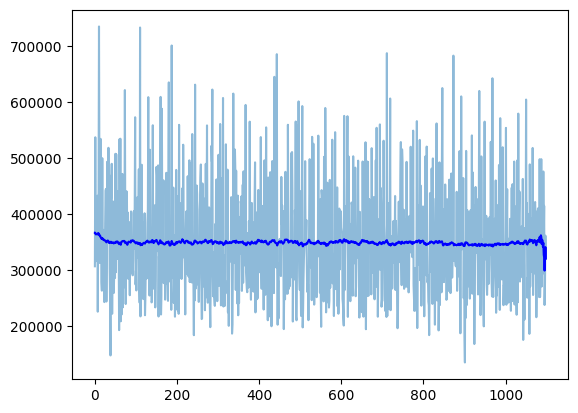

In [24]:
t = pd.read_csv("output.txt")
plotRollingAvg(t.to_numpy())